In [1]:
import numpy as np
from PIL import Image
import accimage
import torch
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-4r9ppmxh because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def input_transforms(img_rgb_orig, target, HW=(256,256), resample=3):
    # return resized L and ab channels as torch Tensors
    img_rgb_rs = resize_img(img_rgb_orig, HW=HW, resample=resample)
    
    img_lab_rs = color.rgb2lab(img_rgb_rs)

    img_l_rs = img_lab_rs[:,:,0]
    img_ab_rs = np.moveaxis(img_lab_rs[:,:,1:], -1, 0)  # (2, 256, 256)

    tens_rs_l = torch.Tensor(img_l_rs)[None,:,:]
    tens_rs_ab = torch.Tensor(img_ab_rs)[:,:]

    return (tens_rs_l, tens_rs_ab)

In [3]:
import torchvision.datasets as dset

root = '/Colorization/data/train2017'
annFile = '/Colorization/data/annotations/instances_train2017.json'
batch_size = 32

dataset = dset.CocoDetection(root=root, annFile=annFile, transforms=input_transforms)

loading annotations into memory...
Done (t=10.31s)
creating index...
index created!


In [24]:
len(dataset.ids)

118287

In [38]:
os.path.abspath('../data/train2017')

'/Colorization/data/train2017'

In [31]:
import glob, os
patch_paths = sorted(glob.glob(os.path.join(root, "*.jpg")))
len(patch_paths), patch_paths

(118287,
 ['/Colorization/data/train2017/000000000009.jpg',
  '/Colorization/data/train2017/000000000025.jpg',
  '/Colorization/data/train2017/000000000030.jpg',
  '/Colorization/data/train2017/000000000034.jpg',
  '/Colorization/data/train2017/000000000036.jpg',
  '/Colorization/data/train2017/000000000042.jpg',
  '/Colorization/data/train2017/000000000049.jpg',
  '/Colorization/data/train2017/000000000061.jpg',
  '/Colorization/data/train2017/000000000064.jpg',
  '/Colorization/data/train2017/000000000071.jpg',
  '/Colorization/data/train2017/000000000072.jpg',
  '/Colorization/data/train2017/000000000073.jpg',
  '/Colorization/data/train2017/000000000074.jpg',
  '/Colorization/data/train2017/000000000077.jpg',
  '/Colorization/data/train2017/000000000078.jpg',
  '/Colorization/data/train2017/000000000081.jpg',
  '/Colorization/data/train2017/000000000086.jpg',
  '/Colorization/data/train2017/000000000089.jpg',
  '/Colorization/data/train2017/000000000092.jpg',
  '/Colorization/data/

## Testing accimage

In [4]:
img_path = '/Colorization/data/test2017/000000581771.jpg'
img_path = '/Colorization/data/val2017/000000007888.jpg'

In [5]:
## PIL
pil_image = Image.open(img_path)
print(pil_image.height, pil_image.width)
pil_image_arr = np.asarray(pil_image)
pil_image_rs = pil_image.resize((256, 256), resample=3)
pil_image_rs_arr = np.asarray(pil_image_rs)

pil_image_arr.shape, pil_image_arr.dtype, pil_image_rs_arr.shape, pil_image_rs_arr.dtype

640 638


((640, 638), dtype('uint8'), (256, 256), dtype('uint8'))

In [5]:
## accimage
acc_image = accimage.Image(img_path)
print(acc_image.height, acc_image.width)
acc_image_arr = np.zeros([acc_image.channels, acc_image.height, acc_image.width], dtype=np.uint8)
acc_image.copyto(acc_image_arr)

acc_image_rs = acc_image.resize((256,256))
acc_image_rs_arr = np.zeros([acc_image_rs.channels, acc_image_rs.height, acc_image_rs.width], dtype=np.uint8)
acc_image_rs.copyto(acc_image_rs_arr)

acc_image_arr.shape, acc_image_arr.dtype, acc_image_rs_arr.shape, acc_image_rs_arr.dtype

640 638


((3, 640, 638), dtype('uint8'), (3, 256, 256), dtype('uint8'))

In [7]:
acc_image = accimage.Image(img_path)
print(acc_image.height, acc_image.width)
acc_image.resize((256, 256), 3)

640 638


In [16]:
resize_opt = transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BICUBIC)
acc_image = accimage.Image(img_path)
print(acc_image.height, acc_image.width)
acc_image_rs = resize_opt.forward(acc_image)

print(acc_image.height, acc_image.width)

640 638
256 256


In [11]:
totensor_opt = transforms.ToTensor()
ten_img = totensor_opt(acc_image)
ten_img.shape

TypeError: Cannot interpret 'torch.float32' as a data type

In [12]:
acc_image_rs_arr = np.zeros([acc_image_rs.channels, acc_image_rs.height, acc_image_rs.width], dtype=np.uint8)
acc_image_rs.copyto(acc_image_rs_arr)

acc_image_rs_arr.shape, acc_image_rs_arr.dtype

((3, 256, 256), dtype('uint8'))

In [34]:
pil_image.height, acc_image.width

(640, 256)

In [20]:
np.moveaxis(acc_image_arr, 0, -1).shape

(640, 638, 3)

In [8]:
np.testing.assert_allclose(pil_image_arr, acc_image_arr[2])

In [19]:
np.testing.assert_allclose(pil_image_rs_arr/255., acc_image_rs_arr[2]/255., rtol=1e-1)

AssertionError: 
Not equal to tolerance rtol=0.1, atol=0

Mismatched elements: 234 / 65536 (0.357%)
Max absolute difference: 0.05882353
Max relative difference: 1.
 x: array([[0.717647, 0.721569, 0.729412, ..., 0.721569, 0.721569, 0.721569],
       [0.721569, 0.729412, 0.729412, ..., 0.729412, 0.733333, 0.733333],
       [0.72549 , 0.729412, 0.729412, ..., 0.733333, 0.733333, 0.737255],...
 y: array([[0.717647, 0.717647, 0.72549 , ..., 0.721569, 0.721569, 0.721569],
       [0.721569, 0.729412, 0.729412, ..., 0.729412, 0.733333, 0.733333],
       [0.72549 , 0.729412, 0.729412, ..., 0.737255, 0.733333, 0.733333],...

In [40]:
acc_image.resize((256, 256)).channels, acc_image.resize((256, 256)).height, acc_image.resize((256, 256)).width

(3, 256, 256)

In [56]:
acc_image.resize((256,256))

In [16]:
np.testing.assert_allclose(pil_image_arr, acc_image_arr[2])

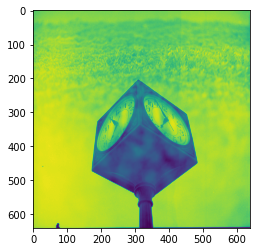

In [17]:
plt.imshow(Image.open(img_path))

In [ ]:
plt.imshow(np.moveaxis(acc_image_rs_arr,0,-1))

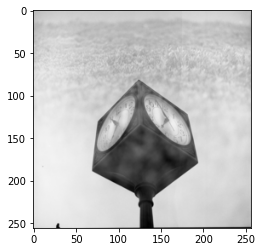

In [11]:
plt.imshow(np.moveaxis(acc_image_rs_arr,0,-1))

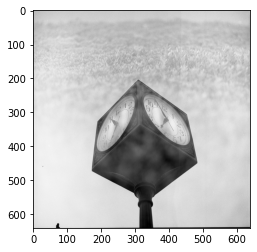

In [20]:
plt.imshow(np.moveaxis(acc_image_arr,0,-1))

TypeError: Image data of dtype object cannot be converted to float

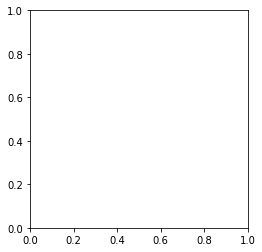

In [18]:
plt.imshow(accimage.Image(img_path))